In [176]:
import pandas as pd
from constraint import Problem, AllDifferentConstraint

In [177]:
exercises_df = pd.read_csv('https://raw.githubusercontent.com/alexwholland/Workout-Planner/main/exrx.csv')
exercises_df.head()

,exercise,utility,mechanics,force,target_muscles,synergist_muscles,stabilizer_muscles,dynamic_stabilizer_muscles,antagonist_stabilizer_muscles
0,Barbell Triceps Extension,Basic or Auxiliary,Isolated,Push,['Triceps Brachii'],['None'],"['Deltoid, Anterior', 'Pectoralis Major, Clavi...",[''],['']
1,Cable Bar Lying Triceps Extension,Basic,Isolated,Push,['Triceps Brachii'],['None'],"['Deltoid, Anterior', 'Pectoralis Major, Clavi...",[''],['']
2,Smith Rear Delt Row,Basic or Auxiliary,Compound,Pull,"['Deltoid, Posterior']","['Infraspinatus', 'Teres Minor', 'Deltoid, Lat...","['Erector Spinae', 'Hamstrings', 'Gluteus Maxi...",['Biceps Brachii'],"['Rectus Abdominis', 'Obliques']"
3,Lever Hack Squat (plate loaded),Basic or Auxiliary,Compound,Push,['Gluteus Maximus'],"['Quadriceps', 'Adductor Magnus', 'Soleus']",[''],"['Hamstrings', 'Gastrocnemius']",['']
4,Sled Lying Reverse Calf Press (plate loaded),Basic or Auxiliary,Isolated,Pull,['Tibialis Anterior'],['None'],['No significant stabilizers'],[''],['']


In [178]:
force_counts = exercises_df['force'].value_counts()
print(force_counts)

Pull            802
Push            654
Push & Pull       4
Pull or Push      2
Pull / Push       1
Name: force, dtype: int64


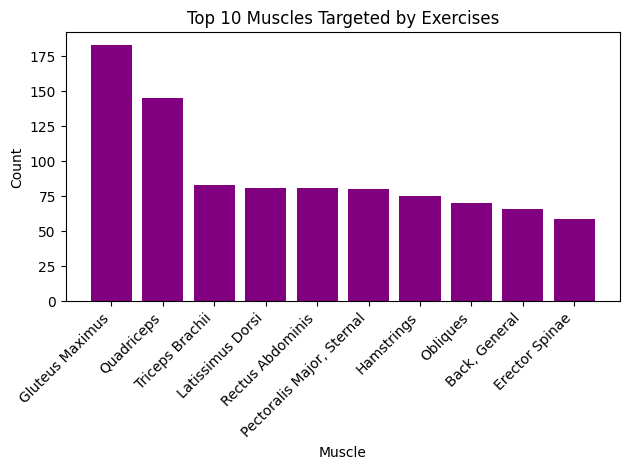

In [179]:
import matplotlib.pyplot as plt

muscles = exercises_df.explode('target_muscles')

muscle_counts = muscles['target_muscles'].value_counts()

top_n = 10
top_muscles = muscle_counts.head(top_n)

# Strip brackets from index labels
top_muscles.index = top_muscles.index.str.strip("[]'")

plt.bar(top_muscles.index, top_muscles, color='purple')
plt.title(f'Top {top_n} Muscles Targeted by Exercises')
plt.xlabel('Muscle')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [180]:
class CSP:
    def __init__(self, variables, domains, constraints, violations):
        self.variables = variables
        self.domains = domains
        self.constraints = constraints
        self.violations = violations

    def init_assignment(self):
        assignment = {var: None for var in self.variables}
        return assignment

    def is_consistent(self, assignment):
        for constraint in self.constraints:
            if not constraint(assignment):
                return False
        return True

    def is_complete(self, assignment):
        return all(assignment[var] is not None for var in self.variables)

    def select_unassigned_variable(self, assignment):
        for var in self.variables:
            if assignment[var] is None:
                return var

def recursive_backtracking(csp, assignment):
    if csp.is_complete(assignment):
        return assignment

    var = csp.select_unassigned_variable(assignment)
    for value in csp.domains:
        assignment[var] = value
        if csp.is_consistent(assignment):
            result = recursive_backtracking(csp, assignment)
            if result is not None:
                return result
        assignment[var] = None

    return None

def unary_constraint(var, violations):
    return lambda asmt: asmt[var] not in violations

def binary_constraint(var_pair, violations):
    (var1, var2) = var_pair
    return lambda asmt: (asmt[var1], asmt[var2]) not in violations

def nary_constraint(var_list, violations):
    return lambda asmt: tuple(asmt[var] for var in var_list) not in violations

In [181]:
variables = ['WA', 'NT', 'Q', 'NSW', 'V', 'SA', 'T']
domains = ['red', 'green', 'blue']
constraints = []
violations = [('red', 'red'), ('green', 'green'), ('blue', 'blue')]

csp = CSP(variables, domains, constraints, violations)

for (var1, var2) in [('WA', 'NT'), ('WA', 'SA'),
                    ('NT', 'SA'), ('NT', 'Q'),
                    ('SA', 'Q'), ('SA', 'NSW'),
                    ('SA', 'V'),('Q', 'NSW'),
                    ('V', 'T')]:
    csp.constraints.append(binary_constraint((var1, var2), violations))

csp.constraints.append(unary_constraint('WA', ('green', 'blue')))

asmt = csp.init_assignment()
result = recursive_backtracking(csp, asmt)
print(result)

{'WA': 'red', 'NT': 'green', 'Q': 'red', 'NSW': 'green', 'V': 'red', 'SA': 'blue', 'T': 'green'}


In [182]:
# scrape the following website using beautiful soup
# https://web.archive.org/web/20231017142951/https://exrx.net/Lists/ExList/ForeArmWt

import requests
from bs4 import BeautifulSoup

url = 'https://web.archive.org/web/20231017142951/https://exrx.net/Lists/ExList/ForeArmWt'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

# save the html to a file

with open('exrx.html', 'w') as f:
    f.write(soup.prettify())

# read the html file into a pandas dataframe

In [183]:
import ast

columns_to_convert = ['target_muscles', 'synergist_muscles', 'stabilizer_muscles', 'dynamic_stabilizer_muscles', 'antagonist_stabilizer_muscles']
for column in columns_to_convert:
    exercises_df[column] = exercises_df[column].apply(ast.literal_eval)

target_muscles_list = [muscle for muscles_list in exercises_df['target_muscles'] for muscle in muscles_list]
synergist_muscles_list = [muscle for muscles_list in exercises_df['synergist_muscles'] for muscle in muscles_list]
stabilizer_muscles_list = [muscle for muscles_list in exercises_df['stabilizer_muscles'] for muscle in muscles_list]
dynamic_stabilizer_muscles_list = [muscle for muscles_list in exercises_df['dynamic_stabilizer_muscles'] for muscle in muscles_list]
antagonist_stabilizer_muscles_list = [muscle for muscles_list in exercises_df['antagonist_stabilizer_muscles'] for muscle in muscles_list]

# Convert the lists to unique sets to remove duplicates
unique_target_muscles = list(set(target_muscles_list))
unique_synergist_muscles = list(set(synergist_muscles_list))
unique_stabilizer_muscles = list(set(stabilizer_muscles_list))
unique_dynamic_stabilizer_muscles = list(set(dynamic_stabilizer_muscles_list))
unique_antagonist_stabilizer_muscles = list(set(antagonist_stabilizer_muscles_list))

# Combine all unique muscles into one set
all_unique_muscles = set(unique_target_muscles + unique_synergist_muscles + unique_stabilizer_muscles +
                         unique_dynamic_stabilizer_muscles + unique_antagonist_stabilizer_muscles)

all_unique_muscles_list = list(all_unique_muscles)

print("Target Muscles:", unique_target_muscles)
print("Synergist Muscles:", unique_synergist_muscles)
print("Stabilizer Muscles:", unique_stabilizer_muscles)
print("Dynamic Stabilizer Muscles:", unique_dynamic_stabilizer_muscles)
print("Antagonist Stabilizer Muscles:", unique_antagonist_stabilizer_muscles)
print("All Unique Muscles:", all_unique_muscles_list)

Target Muscles: ['', 'Serratus Anterior', 'Rectus Abdominis', 'Obliques', 'General, Back', 'Triceps Brachii', 'Extensor Carpi Ulnaris', 'Rhomboids', 'Soleus', 'Pronators', 'Supinator', 'Tibialis Anterior', 'Gluteus Maximus (supporting leg)', 'Trapezius, Upper', 'Flexor Carpi Ulnaris', 'Splenius', 'Wrist Flexors', 'Pectoralis Major, Clavicular', 'Pectoralis Major, Sternal', 'Deltoid, Lateral', 'Wrist Extensors', 'Extensor Carpi Radialis', 'Trapezius, Middle', 'Erector Spinae', ' ', 'Flexor Carpi Radialis', 'Supraspinatus', 'Gastrocnemius', 'Forearm Supinators', '\xa0', 'Quadriceps', 'Compresses and supports abdominal viscera', 'Subscapularis', 'Infraspinatus', 'Gluteus Minimus', 'Gluteus Maximus', 'Deltoid, Posterior', 'Hip Abductors (listed below)', 'Tensor Fasciae Latae', 'Biceps Brachii', 'Hip External Rotators (listed below)', 'Gluteus Medius', 'Forearm Pronators', 'Brachioradialis', 'Transverse Abdominis', 'Latissimus Dorsi', 'Iliopsoas', 'Sternocleidomastoid', 'Back, General', 'Te